In [1]:
import os
import glob
import cv2
import numpy as  np
from scipy.signal import savgol_filter, medfilt
import matplotlib.pyplot as plt
plt.ion()

# configurations that used in the treads detection algorithm
# raw image params
reverse, thresh, bg_level = True, 20.0, 130.0
# system params
baseline, sensor2baseline_offset, d0 = 10.067, 1.25, 5.549
row_num, pix_num, pix_size = 1000, 1500, 0.0055
# tread params
win_size, edge_size, edge_expand = 30, 10, 5
min_tread_width, max_tread_width, max_treads_num, treads_num = 20, 80, 8, 4
min_treads_score = 0.5
# profile smoothing params for Savitzky–Golay smoothing 
spike_size, filt_size, fit_order = 2, 11, 3


def get_img(img_file, row_num, pix_num, reverse, thresh):
    if img_file[-3:] == 'raw':
        image = np.fromfile(img_file, dtype='uint8')
        image = np.reshape(image, (row_num, pix_num))
    elif img_file[-3:] == 'bmp':
        image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    # offset and threshold to remove bg noise
#     image = image[1:-1, 1:-1]
    if reverse:
        image = bg_level - image
    image[image < thresh] = 0
    image -= image.min()
    image *= 255 / image.max()
    
    return image


def get_profile(image, spike_size, filt_size, fit_order):
    profile = (image) * np.arange(image.shape[1])
    profile = profile.sum(axis=1) / (image).sum(axis=1)
    # fill in missing points of the profile
    nans = np.isnan(profile)
    if len(nans.nonzero()[0]):
        profile[nans]= np.interp(nans.nonzero()[0], (~nans).nonzero()[0], profile[~nans])
    # smooth the profile
    if spike_size: 
        profile = medfilt(profile, spike_size * 2 + 1)
    if filt_size:
        profile = savgol_filter(profile, filt_size, fit_order)
        
    return profile


def find_treads(profile_diff, edge_size,  win_size, max_treads_num, min_tread_width):
    n_sects = len(profile_diff) // win_size
    idx4mins = []
    idx4maxs = []
    for i in range(len(profile_diff) // win_size):
        s = i * win_size 
        e = (i + 1) * win_size
        idx4mins.append(s + profile_diff[s : e].argmin())
        idx4maxs.append(s + profile_diff[s : e].argmax())
    
    max2pop = []
    for i in range(len(idx4maxs) - 1):
        if idx4maxs[i+1] - idx4maxs[i] < win_size:
            if (profile_diff[idx4maxs[i]] <= profile_diff[idx4maxs[i+1]]) and (i not in max2pop):
                max2pop.append(i)
            elif i+1 not in max2pop:
                max2pop.append(i + 1)
        
    min2pop = []
    for i in range(len(idx4mins) - 1):
        if idx4mins[i+1] - idx4mins[i] < win_size:
            if profile_diff[idx4mins[i]] >= profile_diff[idx4mins[i+1]] and (i not in min2pop):
                min2pop.append(i)
            elif i+1 not in min2pop:
                min2pop.append(i + 1)
        
    for i in reversed(max2pop):
        idx4maxs.pop(i)
    for i in reversed(min2pop):
        idx4mins.pop(i)

    idx4mins = np.array(idx4mins)
    idx4maxs = np.array(idx4maxs)
    edge_starts = np.sort(idx4maxs[profile_diff[idx4maxs].argsort()[-max_treads_num:]])
    edge_ends = np.sort(idx4mins[profile_diff[idx4mins].argsort()[:max_treads_num]])
    treads_edge = [] 
    for start in edge_starts:
        for end in edge_ends:
            if end <= start:
                continue
            if len(treads_edge) == 0:
                treads_edge.append([start, end])
                continue
            else:
                start0, end0 = treads_edge[-1]
                if start == start0:
                    break
                elif end == end0:
                    treads_edge.pop()
                    treads_edge.append([start, end])
#                 # remove treads overlapping
#                 elif start < end0:
#                     print(start, end, start0, end0)
#                     treads_edge.pop()
#                     treads_edge.append([max(start, start0), min(end, end0)])
                else:
                    treads_edge.append([start, end])

    treads_edge = np.array(treads_edge)
    treads_edge[:, 1] += edge_size 
    treads_width = np.squeeze(np.diff(treads_edge, axis=1))
    treads_edge = treads_edge[(treads_width>min_tread_width) & (treads_width<max_tread_width)]
    return treads_edge


def calibrate_treads(profile, treads_edge, pix_size, edge_expand):
    treads_num = treads_edge.shape[0]
    treads = np.zeros((treads_num, np.diff(treads_edge).max() + edge_expand * 2))
    abs_depth = lambda x : - x * d0 / (x - baseline) 
    for i, (s, e) in enumerate(treads_edge):
        # remove the baseline of the tread, baseline is fitted using beginning and ending points
        ss = s - edge_expand
        ee = e + edge_expand
        tread = abs_depth(profile[ss:ee] * pix_size + baseline + sensor2baseline_offset)
        x = np.concatenate((np.arange(edge_expand), np.arange(len(tread) - edge_expand, len(tread))))
        linear_fit_params = np.polyfit(x, tread[x], 1)
        tread -= np.polyval(linear_fit_params, np.arange(len(tread)))
        pad_before = (treads.shape[1] - len(tread)) // 2
        pad_after = treads.shape[1] - len(tread) - pad_before
        treads[i] = np.pad(tread, (pad_before, pad_after), 'constant')

    return treads


def get_treads_score(profile_diff, treads_depth, idx_peaks_dips):
    w1, w2, w3 = 1, -1, -1
    norm_treads_depth = treads_depth / treads_depth.max()
    treads_unflatness = []
    for (idx_peak, idx_dip) in idx_peaks_dips:
        peak, dip = profile_diff[idx_peak], profile_diff[idx_dip]
        sub_peak = max(profile_diff[(idx_peak + idx_dip) // 2: idx_dip + 1])
        sub_dip = min(profile_diff[idx_peak: (idx_peak + idx_dip) // 2 + 1])
        treads_unflatness.append(abs((sub_peak - sub_dip)/(peak-dip)))
    treads_unflatness = np.array(treads_unflatness)
        
    peaks, dips = profile_diff[idx_peaks_dips].T
    peak_dip_mismatch = abs((peaks + dips)/(peaks - dips))
    treads_score = w1 * norm_treads_depth + w2 * treads_unflatness + w3 * peak_dip_mismatch
    max_score = w1
    min_score = w2 + w3
    treads_score -= min_score
    treads_score /= max_score - min_score
    return treads_score
   

In [4]:
folder = r'C:\Users\MPNV38\ZDevelop\tiretread\data\SE655POC\from_Neeharika'
files = glob.glob(os.path.join(folder, '07.bmp'))
img = get_img(files[0], row_num, pix_num, reverse=reverse, thresh=thresh)
profile = get_profile(img, spike_size, filt_size, fit_order)

c:\users\mpnv38\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


c:\users\mpnv38\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


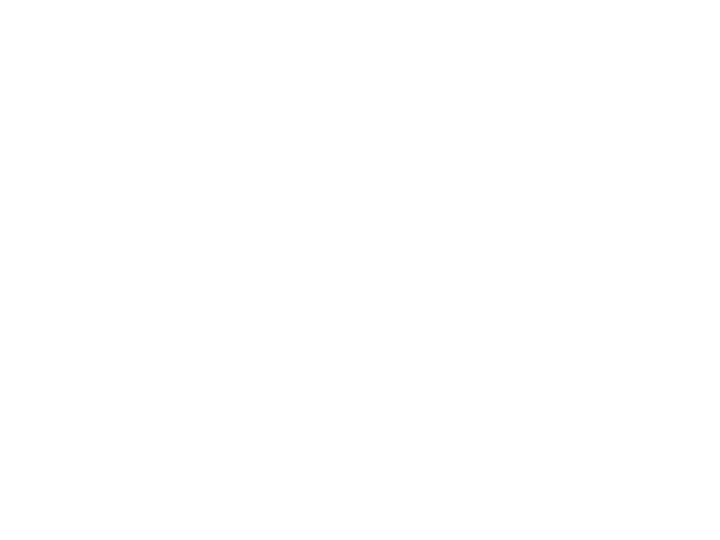

In [27]:
folder = r'C:\Users\MPNV38\ZDevelop\tiretread\data\SE655POC\from_Neeharika'
files = glob.glob(os.path.join(folder, '07.bmp'))

for i, img_file in enumerate(files[:]):
    img = get_img(img_file, row_num, pix_num, reverse=reverse, thresh=thresh)
    profile = get_profile(img, spike_size, filt_size, fit_order)
    profile_diff = profile[:-edge_size] - profile[edge_size:]
    
    treads_edge = find_treads(profile_diff, edge_size, win_size, max_treads_num,  min_tread_width)
    treads = calibrate_treads(profile, treads_edge, pix_size, edge_expand)
    treads_depth = - treads.min(axis=1)
    
    idx_peaks_dips = treads_edge - [0, edge_size]
    treads_score = get_treads_score(profile_diff, treads_depth, idx_peaks_dips)
    picked_treads_idx = (treads_score.argsort())[-treads_num:]
    picked_treads_idx = picked_treads_idx[treads_score[picked_treads_idx] > min_treads_score]
    picked_treads_idx.sort()
    
    picked_treads = treads[picked_treads_idx]
    picked_treads_depth = treads_depth[picked_treads_idx]
    picked_treads_score = treads_score[picked_treads_idx]
    picked_treads_edge = treads_edge[picked_treads_idx]
    
    tread_legend = []
    for i, d in zip(picked_treads_idx, picked_treads_depth):
        tread_legend.append('T{:d} : {:.0f}/32'.format(i + 1, d * 32/ 25.4))
        
    resized_img = np.flipud(img[:, int(profile.min()):int(profile.max())].T)
    plt.figure()
    plt.subplot(311)
    plt.imshow(resized_img, aspect=0.1 * resized_img.shape[1]/resized_img.shape[0], vmax=100)
    
    plt.subplot(312)
    plt.plot(profile)
    for (s, e) in treads_edge:
        plt.axvline(x=s, color='r')
        plt.axvline(x=e, color='r')
    for (s, e) in picked_treads_edge:
        plt.axvline(x=s, color='g')
        plt.axvline(x=e, color='g')
        plt.xlim(0, len(profile))
        
    plt.subplot(313)
    if len(treads):
        plt.plot(picked_treads.T)
        plt.legend(tread_legend)
#         plt.legend([''.join(("tread depth:", "%.2f" % x, "mm")) for x in picked_treads_depth])
    
    plt.show()
#     plt.savefig(os.path.join(folder, "profiles", os.path.basename(img_file) + '.png'))
    if i > 0:
        plt.close('all')

In [15]:
%matplotlib

Using matplotlib backend: nbAgg
